# Reproducing Biomedical Image Segmentation in the U-Net paper

In this notebook we try to fully reproduce the method presented in the paper ["U-Net: Convolutional Networks for Biomedical Segmentation"](https://arxiv.org/pdf/1505.04597.pdf), particularly, the results presented in table 2 and the pixel error of the U-Net reported in table 1.
The following implementation was carried out without using the pre-existing code, made available by the authors.

## How does U-Net work ?

The U-Net is a convolutional network architecture for fast and precise segmentation of images. It learns segmentation in an end-to-end setting: a raw image is given in input and the output is the segmentation map.

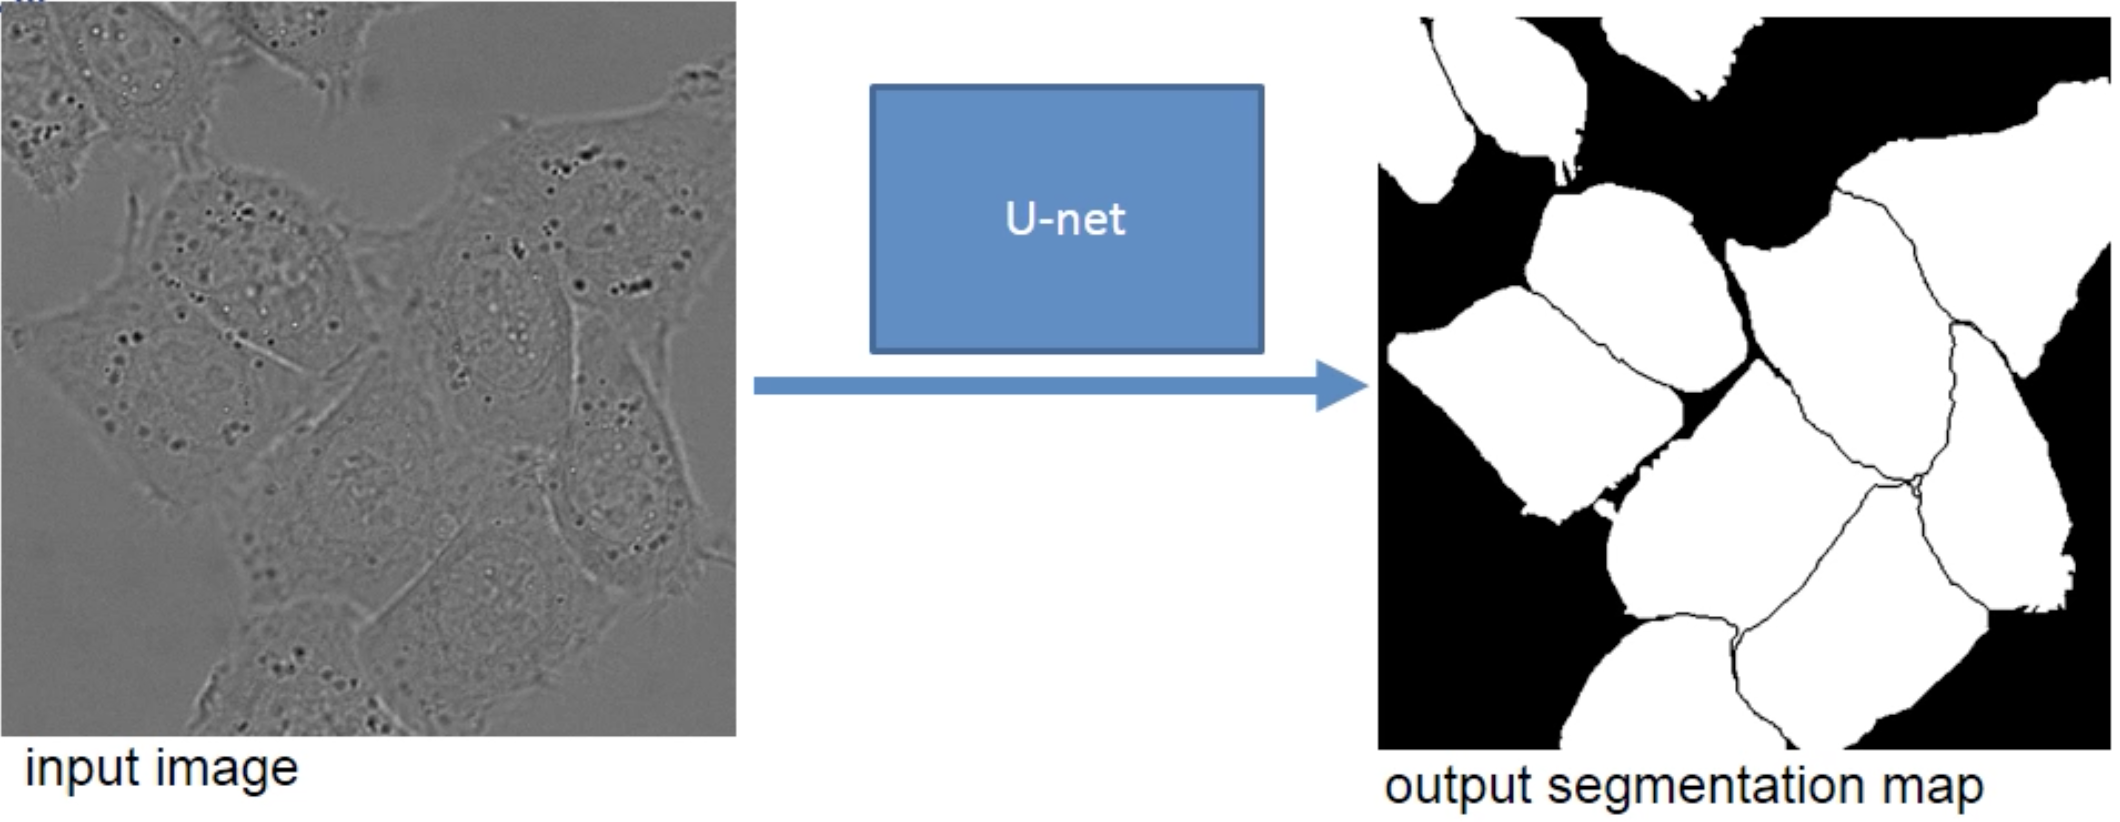

Convolutional network are typically used for classification tasks, so that the obtained output for an input image is a single class label. However, in the considered task of biomedical image segmentation, the desired output has to include localization, that means a class labes must be assigned to each pixel of the image.
To achieve this goal, the paper proposes the U-Net architecture: a contracting path used to capture context in the input image is supplemented with a symmetric expanding path that enables precise localization.

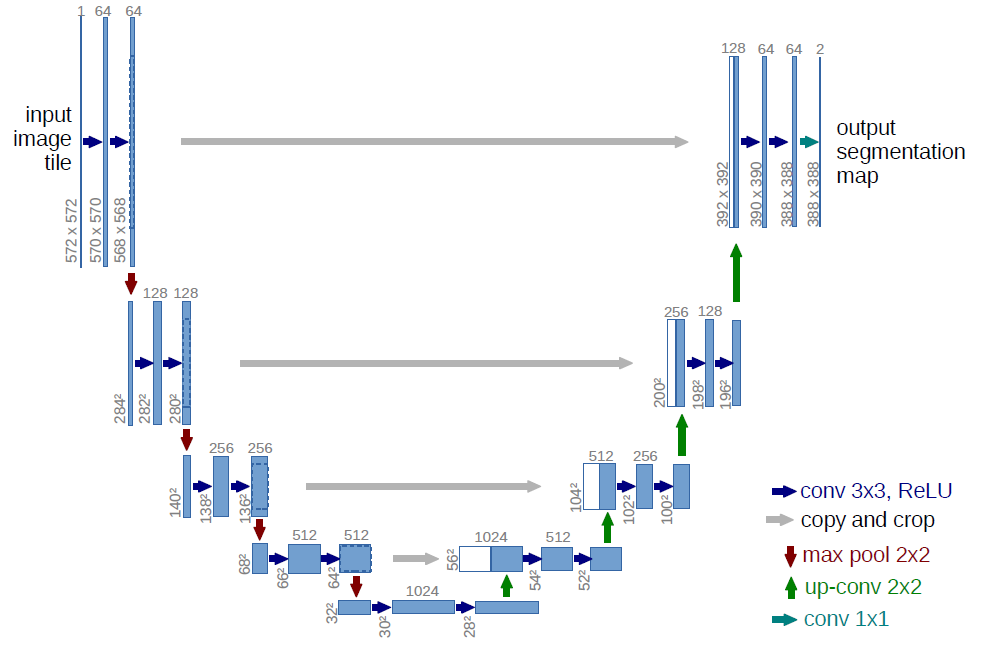

As the previuos image shows, the input image is fed into the network, then the data are propagated into the network according to the displayed path and finally the segmentation map is given as output.
Each blue box corresponds to a multi-channel feature map: the x-y size is reported on the edge, while the number of channel is denoted on top of the box.
The contracting path mimics the classical architecture of a convolutional network with the repeated application of two 3x3 unpadded convolutions each followed by a ReLU and a 2x2 max pooling operation with stride 2.
In the expanding path, the pooling operators are replaced by upsampling operators, 2x2 convolution, that increase the resolution of the output. To achieve localization, high resolution cropped features map from the contracting path are combined with the upsampled output using a concatenation, represented by the grey arrows.
Finally the last layer applies a 1x1 convolution to obtain the output segmentation map with two channels: one for the foreground class and the other for the background one.

Due the unpadded convolution the output is smaller than the input images. As shown by the next figure, the segmentatiom of the yellow area uses iput data of the blue area. This strategy is called "overlap-tile strategy" and thank it allows the segmentation of arbitrarily large images. At the border, data are extrapolated by mirroring.

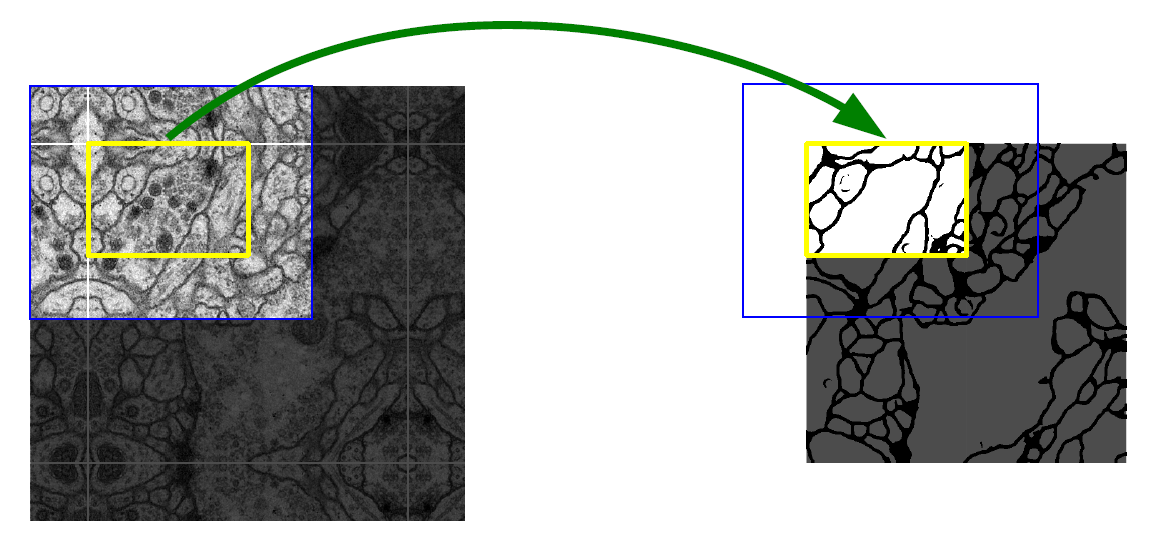

The challenges the paper deals with are the availability of few annotated images, componing the dataset, and the presence of touching objects of the same class that need to be separated by the segmentation algorithm.

The presented training strategy relies indeed on strong use of data augmentation and adopt a weighted loss, detailed later in this notebook, to deal with separation of touching objects of the same class.

## Experiment Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import cv2 as cv
import os
import shutil
from batchgenerators.utilities.file_and_folder_operations import maybe_mkdir_p

from torchvision.utils import save_image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data import download_all_data, preprocess_gt, ImageDataset, ImageDataset_test
from network import Unet
from functions import weighted_map, input_size_compute, evaluation_metrics

from time import time

CUR_DIR = os.path.abspath('')

# Dataset


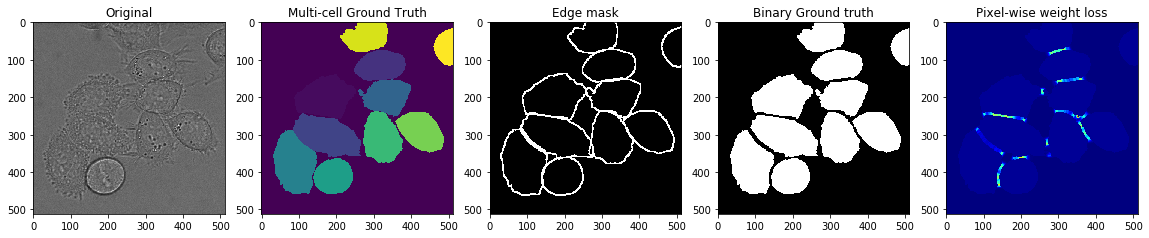

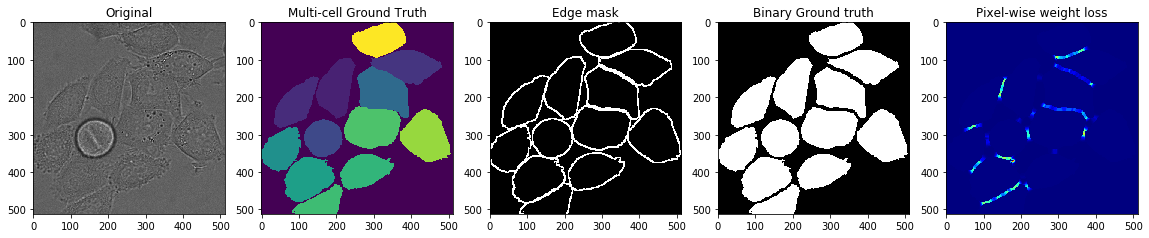

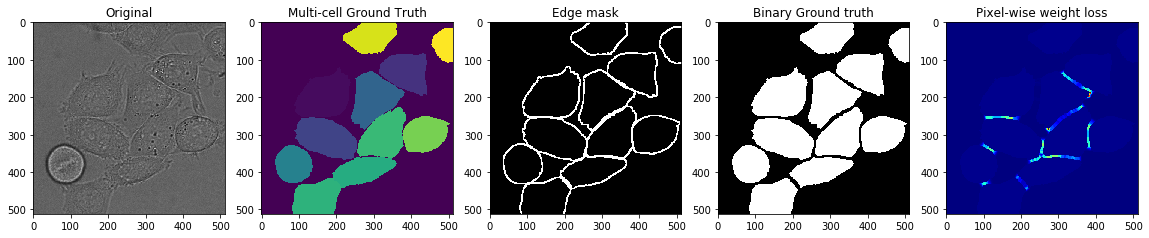

In [2]:
# Download data
download_all_data()

# Specify which dataset to analyse
# DATASET = 'PhC-C2DH-U373' # [520, 696]
# DATASET = 'ISBI2012'
DATASET = 'DIC-C2DH-HeLa'

ISBI2012 = False

if DATASET == 'PhC-C2DH-U373':
    crop = 196
else:
    crop = 388

training_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01")

if DATASET == 'ISBI2012':
    ISBI2012 = True
    target_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_GT", "SEG")
    target = os.listdir(target_path)    
else:
    target_GT_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_GT", "SEG")
    target_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_ST", "SEG")
    target_GT = os.listdir(target_GT_path)
    for image in target_GT:
        os.remove(os.path.join(target_path, image)) 
    target = os.listdir(target_path)    
    for image in target_GT:
        shutil.copyfile(os.path.join(target_GT_path, image), os.path.join(target_path, image))

for i in range(3):
    # load images
    img_training = cv.imread(os.path.join(training_path, f"t{target[i][7:]}"), -1)
    img_gt = cv.imread(os.path.join(target_path, target[i]), -1)
    
    # image morphology, for edge detection (ONLY FOR DIC-C2DH-HeLa, since cells intersect)
    gt, mask_global = preprocess_gt(img_gt)
    if DATASET != "DIC-C2DH-HeLa":
        gt = img_gt
    
    fig = plt.figure(figsize=(16,9))
    plt.subplot(1,5,1)
    plt.imshow(img_training, cmap='gray')
    plt.title("Original")
    plt.subplot(1,5,2)
    plt.imshow(img_gt)
    plt.title('Multi-cell Ground Truth')
    plt.subplot(1,5,3)
    plt.title('Edge mask')
    plt.imshow(mask_global > 0, cmap='gray')  # binary of cell edges
    plt.subplot(1,5,4)

    _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
    plt.imshow(torch.from_numpy(gt_bin.astype('uint8')), cmap='gray')
    plt.title('Binary Ground truth')
    
    # Calculating loss for ground truth
    loss_img = weighted_map(torch.from_numpy(gt_bin.reshape((1,1,img_training.shape[0],img_training.shape[1])).astype('float32')) / 255).numpy().reshape((img_training.shape[0],img_training.shape[1]))
    plt.subplot(1,5,5)
    plt.imshow(loss_img, cmap='jet')
    plt.title("Pixel-wise weight loss")
    plt.tight_layout()
    plt.show()

# Data Augmentation

One of the main challenge in biomedical image segmentation is the low number of training data. Data augmentation is indeed required and, particularly, in this paper random elastic deformation is used: this allows the network to learn invariance to such deformation and, moreover, it is important in the considered framework due to the fact deformation is used to be the most common variation in tissue.

Explanation second paper

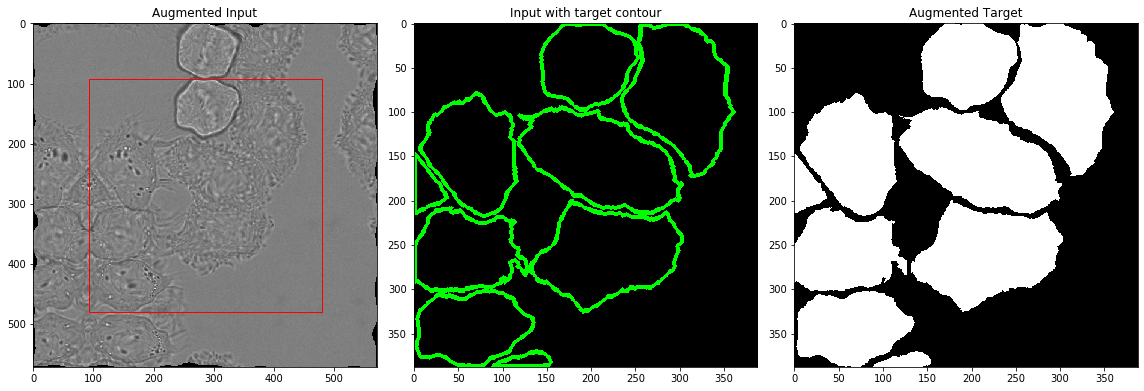

In [3]:
root_dir = os.path.join(CUR_DIR, "data", f"{DATASET}-training")
data = ImageDataset(root_dir, alpha=200, sigma=10, crop=crop, ISBI2012=ISBI2012)   # For training + validation

orig_img = cv.imread(os.path.join(root_dir, '01', os.listdir(os.path.join(root_dir, "01"))[0]), -1)

img, gt = data[0]

original_size, input_size, _ = input_size_compute(gt)
pad = int((input_size - original_size) / 2)

fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

rect = patches.Rectangle((pad,pad),original_size,original_size,linewidth=1,edgecolor='r',facecolor='none')
gt = gt.reshape(gt.shape[1:]).numpy().astype(np.uint8)
contours, hierarchy = cv.findContours(gt, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
image = cv.cvtColor(img.reshape(img.shape[1:])[pad:pad+original_size,pad:pad+original_size].numpy().astype(np.uint8),cv.COLOR_GRAY2RGB)
cv.drawContours(image, contours, -1, (0, 255, 0), 3)

ax0.imshow(img.reshape(img.shape[1:]), cmap='gray')
ax0.add_patch(rect)
ax0.set_title('Augmented Input')
ax1.imshow(image)
ax1.set_title('Input with target contour')
ax2.imshow(gt, cmap='gray')
ax2.set_title('Augmented Target')

fig.tight_layout()
plt.show()

# Training

In [4]:
# Parameters:
val_per = 0.2
tr_per  = 1.0 - val_per
batch_size = 1
epochs = 2

In [5]:
root_dir = os.path.join(CUR_DIR, "data", f"{DATASET}-training")
train_dataset = ImageDataset(root_dir, alpha=200, sigma=10, ISBI2012=ISBI2012)   # For training + validation

samp_tr  = int(np.round(tr_per  * len(train_dataset)))
samp_val = int(np.round(val_per * len(train_dataset)))

# We round numbers so that we do not exceed total number of samples
while samp_tr + samp_val > len(train_dataset):
    samp_val += -1

# We generate an order vector to shuffle the samples before each fold for the cross validation  
order = np.arange(len(train_dataset))
np.random.shuffle(order)

# Suffle the training set
train_dataset = [train_dataset[idx] for idx in order]

# Divide between training and validation sets by order (in notebook we only use a few images for speed purposes)
train_set = train_dataset[0:2]
val_set   = train_dataset[2:3]

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=True)

# Shift values in order for next fold of cross validation (a shift of samp_val)
order = np.append(order[samp_val:], order[0:samp_val])
        
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')

else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


In [6]:
# To be called as: training(unet, train_loader, val_loader, epochs, batch_size, device, fold_dir):

train_dir = os.path.join(CUR_DIR, 'nb_train')
maybe_mkdir_p(train_dir)

torch.cuda.empty_cache()
unet = Unet().to(device)

optimizer = optim.SGD(unet.parameters(), lr=0.001, momentum=0.99)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, threshold=1e-2, threshold_mode='rel', eps=1e-7)
my_patience = 0

maybe_mkdir_p(os.path.join(train_dir, 'progress'))
maybe_mkdir_p(os.path.join(train_dir, 'models' ))

loss_best_epoch = 100000.0

for epoch in range(epochs+1):
    
    print(' ')
    print('Epoch:', epoch)

    start = time()
    total_loss = 0
    total_loss_val = 0
    start_eval_train = 0
    start_eval_val = 0

    for batch in train_loader:

        optimizer.zero_grad()

        images, labels = batch
        preds = unet(images.to(device)) # pass batch to the unet

        pad = int((preds.shape[-1] - labels.shape[-1]) / 2)
        preds = preds[:, :, pad:labels.shape[-1]+pad, pad:labels.shape[-1]+pad]

        ll = torch.empty_like(preds)
        ll[:,0,:,:] = 1 - labels[:, 0, :, :]  # background
        ll[:,1,:,:] = labels[:, 0, :, :]  # cell
        ll = ll.to(device)

        weight_maps = weighted_map(labels).to(device)
        criterion = nn.BCEWithLogitsLoss(weight=weight_maps)
        loss = criterion(preds, ll)

        loss.backward() # compute the gradients using backprop
        optimizer.step() # update the weights

        total_loss += loss

        preds = preds.argmax(dim=1)

        for idx in range(preds.shape[0]):
            if start_eval_train == 0 and idx == 0: # First time in epoch we initialize train_eval
                train_eval = evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())
                start_eval_train += 1
            else:
                np.concatenate((train_eval, evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())), axis=1)

    train_eval_epoch = np.mean(train_eval, axis=1)

    with torch.no_grad():
        for batch in val_loader:
            
            images, labels = batch
            preds = unet(images.to(device))

            pad = int((preds.shape[-1] - labels.shape[-1]) / 2)
            preds = preds[:, :, pad:labels.shape[-1]+pad, pad:labels.shape[-1]+pad]

            ll = torch.empty_like(preds)
            ll[:,0,:,:] = 1 - labels[:, 0, :, :] # background
            ll[:,1,:,:] = labels[:, 0, :, :] # cell
            ll = ll.to(device)

            weight_maps = weighted_map(labels).to(device)
            criterion = nn.BCEWithLogitsLoss(weight=weight_maps)
            loss = criterion(preds, ll)

            total_loss_val += loss

            preds = preds.argmax(1)

            for idx in range(preds.shape[0]):
                if start_eval_val == 0 and idx == 0: # First time in epoch we initialize val_eval
                    val_eval = evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())
                    start_eval_val += 1
                else:
                    np.concatenate((val_eval, evaluation_metrics(preds[idx, :, :].detach(), labels[idx, 0, :, :].detach())), axis=1)

    val_eval_epoch = np.mean(val_eval, axis=1)

    scheduler.step(total_loss_val / (len(val_loader) * batch_size)) # update the lr

    for param_group in optimizer.param_groups: l_rate = param_group['lr']

    loss_epoch     = total_loss / (len(train_loader) * batch_size)
    loss_epoch_val = total_loss_val / (len(val_loader) * batch_size)

    if loss_epoch_val < (loss_best_epoch * (1.0 - scheduler.threshold)):
        loss_best_epoch = loss_epoch_val
        print('New best epoch!')
        my_patience = 0
        PATH = os.path.join(train_dir, 'models', 'unet_weight_save_best.pth')
        torch.save(unet.state_dict(), PATH)
        print('Model has been saved:')
        print(PATH)
    else:
        my_patience += 1

    print('Current lr is:             ', l_rate                                      )
    print('Patience is:                {}/{}'.format(my_patience, scheduler.patience))
    print('Mean IoU training:         ', "{:.6f}".format(train_eval_epoch[0])        )
    print('Mean PE training:          ', "{:.6f}".format(train_eval_epoch[1])        )
    print('Mean IoU validation:       ', "{:.6f}".format(val_eval_epoch[0])          )
    print('Mean PE validation:        ', "{:.6f}".format(val_eval_epoch[1])          )
    print('Total training loss:       ', "{:.6f}".format(loss_epoch.item())          )
    print('Total validation loss:     ', "{:.6f}".format(loss_epoch_val.item())      )
    print('Best epoch validation loss:', "{:.6f}".format(loss_best_epoch.item())     )
    print('Epoch duration:            ', "{:.6f}".format(time()-start), 's'          )
    print('                                                                         ')

    # Save progress (evaluation metrics and loss)
    if epoch == 0:
        train_eval_progress_iou = [train_eval_epoch[0]]
        train_eval_progress_pe  = [train_eval_epoch[1]]
        val_eval_progress_iou   = [val_eval_epoch[0]]
        val_eval_progress_pe    = [val_eval_epoch[1]]
        loss_progress           = [loss_epoch.item()]
        loss_progress_val       = [loss_epoch_val.item()]
    elif epoch > 0:
        train_eval_progress_iou = np.concatenate((train_eval_progress_iou, [train_eval_epoch[0]]))
        train_eval_progress_pe  = np.concatenate((train_eval_progress_pe, [train_eval_epoch[1]]) )
        val_eval_progress_iou   = np.concatenate((val_eval_progress_iou, [val_eval_epoch[0]])    )
        val_eval_progress_pe    = np.concatenate((val_eval_progress_pe, [val_eval_epoch[1]])     )
        loss_progress           = np.append(loss_progress, [loss_epoch.item()]                   )
        loss_progress_val       = np.append(loss_progress_val, [loss_epoch_val.item()]           )

    np.savetxt(os.path.join(train_dir, 'train_eval_iou.out'), train_eval_progress_iou)
    np.savetxt(os.path.join(train_dir, 'train_eval_pe.out' ), train_eval_progress_pe )
    np.savetxt(os.path.join(train_dir, 'val_eval_iou.out'  ), val_eval_progress_iou  )
    np.savetxt(os.path.join(train_dir, 'val_eval_pe.out'   ), val_eval_progress_pe   )
    np.savetxt(os.path.join(train_dir, 'loss.out'          ), loss_progress          )
    np.savetxt(os.path.join(train_dir, 'loss_val.out'      ), loss_progress_val      )

    if l_rate < 10 * scheduler.eps and my_patience == scheduler.patience:
        print(f'LR dropped below {10 * scheduler.eps}!')
        print('Stopping training')
        break

    if my_patience == scheduler.patience: my_patience = 0

print('Training is finished as epoch {} has been reached'.format(epochs))


Epoch: 0
New best epoch!
Model has been saved:
/Users/pere/opt/anaconda3/envs/DL_Delft/DL-unet/nb_train/models/unet_weight_save_best.pth
Current lr is:              0.001
Patience is:                0/20
Mean IoU training:          0.301598
Mean PE training:           0.001903
Mean IoU validation:        0.455720
Mean PE validation:         0.001760
Total training loss:        4.809484
Total validation loss:      1.923891
Best epoch validation loss: 1.923891
Epoch duration:             33.426249 s
                                                                         
 
Epoch: 1
New best epoch!
Model has been saved:
/Users/pere/opt/anaconda3/envs/DL_Delft/DL-unet/nb_train/models/unet_weight_save_best.pth
Current lr is:              0.001
Patience is:                0/20
Mean IoU training:          0.439828
Mean PE training:           0.001777
Mean IoU validation:        0.465212
Mean PE validation:         0.001748
Total training loss:        1.738813
Total validation loss:      1.2

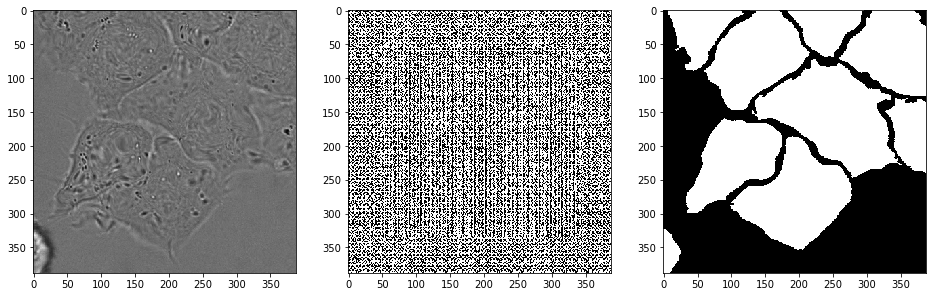

In [7]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    original_size, input_size, _ = input_size_compute(gt)
    pad = int((input_size - original_size) / 2)

    ax0.imshow(images[0, 0, pad:original_size+pad, pad:original_size+pad].detach(), cmap='gray')
    ax1.imshow(preds[0, :, :].detach(), cmap='gray')
    ax2.imshow(labels[0, 0, :, :].detach(), cmap='gray')

# Testing

In [8]:
NETWORK = f'models/{DATASET}/random_cropping_388/fold0/models/unet_weight_save_best.pth'
# NETWORK = 'nb_test/unet_weight_save_5000.pth'
model_path = os.path.join(CUR_DIR, NETWORK)
from data import ImageDataset_test

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

# Get test data
test_dataset  = ImageDataset_test(root_dir, ISBI2012=False)   
test_dataset  = [test_dataset[idx] for idx in range(len(test_dataset))]
test_set      = test_dataset           
test_loader   = DataLoader(test_set, batch_size=1, shuffle=False)

# Make directory for test outputs (assumes .pth format)
output_dir = model_path[0:len(model_path)-4] + '_test'
maybe_mkdir_p(output_dir)

torch.cuda.empty_cache()
unet = Unet().to(device)
unet.load_state_dict(torch.load(model_path, map_location=device))

Running on the CPU


<All keys matched successfully>

In [10]:
# To be called as: testing(unet, test_loader, batch_size, device, output_dir)

start = time()
start_eval_test = 0
idx = 0

maybe_mkdir_p(os.path.join(output_dir, 'images'))
maybe_mkdir_p(os.path.join(output_dir, 'preds' ))
maybe_mkdir_p(os.path.join(output_dir, 'labels'))

for batch in test_loader:
    
    image, label = batch

    pred = unet(image.to(device))

    pad = int((pred.shape[-1] - label.shape[-1]) / 2)
    pred = pred[:, :, pad:label.shape[-1]+pad, pad:label.shape[-1]+pad].argmax(dim=1)
    pad = int((image.shape[-1] - label.shape[-1]) / 2)
    image = image[0, 0, pad:label.shape[-1]+pad, pad:label.shape[-1]+pad]
    label = label[0, 0, :, :].float()
    pred = pred[0, :, :].float()

    save_image(image, os.path.join(output_dir, 'images', f'image{idx}.tif'))
    save_image(label, os.path.join(output_dir, 'labels', f'label{idx}.tif'))
    save_image(pred,  os.path.join(output_dir, 'preds',  f'pred{idx}.tif' ))

    idx += 1

    if start_eval_test == 0: 
        test_eval = evaluation_metrics(pred.detach(), label.detach())
        start_eval_test += 1
    else:
        np.concatenate((test_eval, evaluation_metrics(pred.detach(), label.detach())), axis=1)

test = np.mean(test_eval, axis=1)

test_iou = [test[0]]
test_pe  = [test[1]]
np.savetxt(os.path.join(output_dir, 'test_iou.out'), test_iou)
np.savetxt(os.path.join(output_dir, 'test_pe.out' ), test_pe )

print('Mean IoU testing:', "{:.6f}".format(test[0])          )
print('Mean PE testing :', "{:.6f}".format(test[1])          )
print('Testing took    :', "{:.6f}".format(time()-start), 's')
print('                                                     ')

print('Testing is finished')

Mean IoU testing: 0.754635
Mean PE testing : 0.000686
Testing took    : 130.379310 s
                                                     
Testing is finished


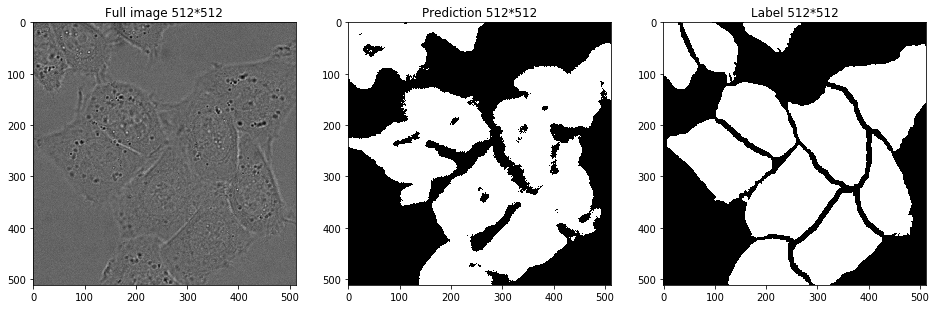

In [12]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    pad = int((image.shape[-1] - label.shape[-1]) / 2)

    ax0.imshow(image.detach(), cmap='gray')
    ax1.imshow(pred.detach(),  cmap='gray')
    ax2.imshow(label.detach(), cmap='gray')

    ax0.set_title('Full image 512*512')
    ax1.set_title('Prediction 512*512')
    ax2.set_title('Label 512*512')

In [15]:
from functions import weighted_map

w = weighted_map(label.reshape([-1,label.shape[0],label.shape[1]]))
print(w.shape)

torch.Size([1, 512, 512])


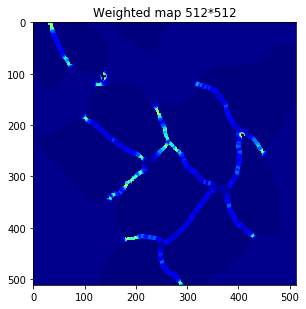

In [17]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax0.imshow(w[0, :, :].detach(), cmap='jet')
    ax0.set_title('Weighted map 512*512')

    #### Would be a good idea to put a colorbar